In [23]:
import numpy as np
import math
from matplotlib import pyplot as plt
import time
import scipy.stats
import pandas as pd
import random

## Create Electronic Model Class

In [24]:
# Tolerances of electronic components
# Used to initialize the class

Vout = np.array([3.2, 3.3, 3.4])
LS_Ron = np.array([6.3, 8.3, 11])*1e-3
Iout = np.array([2.64, 3.03, 3.45])
Vin = np.array([13.3, 13.35, 13.37])
Fsw = np.array([430, 455, 489])*1e3
Vbody_diode = np.array([0.65, 0.8, 1.2])
L = np.array([5.4, 4.5, 3.6])*1e-6
DCR = np.array([12.61, 19, 27.23])*1e-3
P_IC = np.array([83.93, 88.81, 93.69])*1e-3

In [25]:
# Initialize Class
from PSU_class import PSU

model = PSU(Vout, LS_Ron, Iout, Vin, Fsw, Vbody_diode, L, DCR, P_IC)
model.P_in()

array([ 9.28592306, 10.85749529, 12.66975792])

## Simulate from Class

In [26]:
# Number of simulations
n_simulation = 20000

In [27]:
# Simulate output with parameters with Uniform Distribution
from helper_functions import simulation
random.seed(12345)

simulation = simulation(n_simulation, model, PSU, "Gauss")

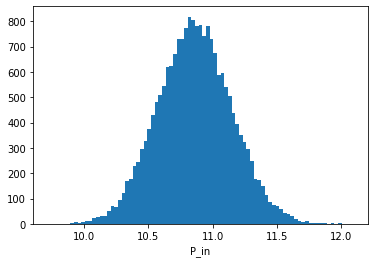

In [28]:
# Plot historgram
plt.hist(simulation, bins = 'auto')
plt.xlabel('P_in')
plt.show()

## Model Selection Methods

### Chi-Square

In [30]:
from helper_functions import compute_chi_square

random.seed(345)

results = compute_chi_square(simulation)

Distribution: weibull_min || Parameters: (4.380343462929506, 9.714232485438774, 1.2540567297097422)
Distribution: norm || Parameters: (10.858361537028248, 0.28763272446566895)
Distribution: weibull_max || Parameters: (4.759634677550375, 12.09653642150128, 1.3505087833288179)
Distribution: beta || Parameters: (6102.915371094845, 10000159.283258425, -11.617080077384983, 36850.44571255066)
Distribution: invgauss || Parameters: (0.014940335536522145, 8.430578699754658, 162.40307358338998)
Distribution: uniform || Parameters: (9.720890345702554, 2.3674224915102116)
Distribution: gamma || Parameters: (6516.562691174284, -12.360965649159251, 0.003563124671414058)
Distribution: expon || Parameters: (9.720890345702554, 1.1374711913256945)
Distribution: lognorm || Parameters: (0.01326944390424718, -10.793946193280313, 21.65055846535037)
Distribution: pearson3 || Parameters: (0.024555546339017305, 10.858362077992613, 0.28762174703049115)
Distribution: triang || Parameters: (0.47147773748561506, 9

**Model A:** Normal Distribution

**Model B:** Beta Distribution

### Non-Nested Likelihood Ratio Test

Compare **Model A** to **Model B** and choose the best fit. 

In [8]:
from helper_functions import LRT

Q, qQi = LRT(results.iloc[:2], 1000, n_simulation)
if Q < qQi: print('Select model A')

Select model A


### Q-Q Plot

Compare **Model A** to **Model B** on a quantile-quantile plot. 

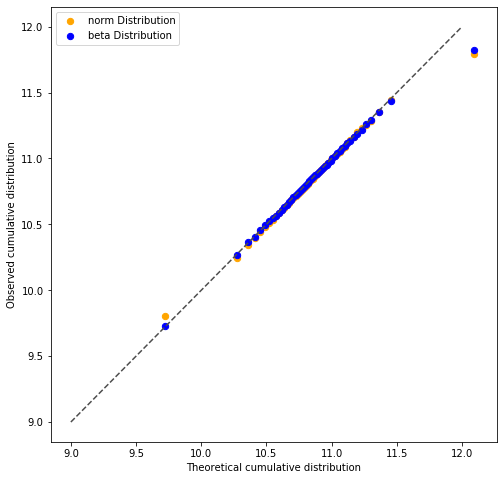

In [9]:
from helper_functions import qqplot

qqplot(simulation, results)

### Chosen Model Description

In [10]:
best_name = results.iloc[0]['Distribution']
best_params = results.iloc[0]['Parameters']

best_dist = getattr(scipy.stats, best_name)

## Plot Choosen Model Againts Data

In [11]:
import seaborn as sns

**Simulated Data Histogram**

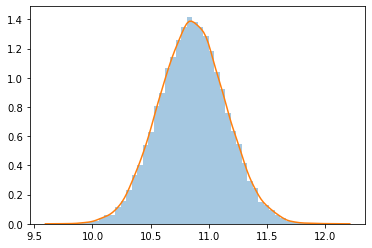

In [12]:
sns.distplot(a = simulation, kde = False, norm_hist=True)
sns.kdeplot(data = simulation, shade= False)

**Chosen Distribution Density Function**

In [13]:
simulation.sort()

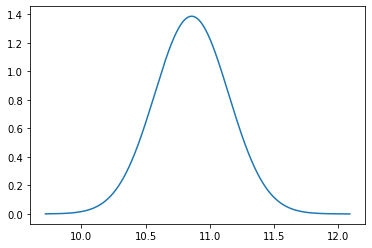

In [14]:
plt.plot(simulation, best_dist.pdf(simulation,*best_params))

**Chosen Distribution on top of Simulated Data Histogram**

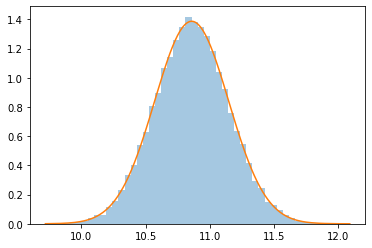

In [15]:
sns.distplot(a = simulation, kde = False, norm_hist=True)
plt.plot(simulation, best_dist.pdf(simulation, *best_params))

## Validation Methods

### Kolmogorov-Smirnoff 2 Sample Test

In [16]:
from scipy.stats import ks_2samp

In [17]:
data1 = np.random.choice(a = simulation, size = 2000)
data2 = best_dist.rvs(*best_params, size = 2000)
statistic, pvalue = ks_2samp(data1,data2)
print(f"The Statistic value is: {statistic} \nThe p_value is: {pvalue}")

The Statistic value is: 0.0205 
The p_value is: 0.7948265413398378


In [18]:
n1 = len(data1)
n2 = len(data2)
alpha = 0.05
c_alpha = 1.36 # https://sparky.rice.edu//astr360/kstest.pdf
critical_value = c_alpha * ((n1 + n2)/(n1*n2))**0.5 
critical_value

0.04300697617828996

In [19]:
if statistic > critical_value:
    print('The two samples come from different distributions')
else:
    print('The two samples come from same distributions')

The two samples come from same distributions


## Work Within Limits

### Quantiles

In [20]:
quantiles = best_dist.ppf([0.0001, 0.5, 0.9999], *best_params)
quantiles

array([ 9.78865069, 10.85836154, 11.92807238])

### Cp

In [21]:
# This value depends on the best distribution
sigma = best_params[1]

In [22]:
limit_min = model.P_in()[0]
limit_MAX = model.P_in()[2] 
Cp = (limit_MAX - limit_min)/(6 * sigma)
Cp

1.960738224701146